# Case Study #1 - Danny's Diner
#### https://8weeksqlchallenge.com/case-study-1/

## Q1. What is the total amount each customer spent at the restaurant?

In [ ]:
select a.customer_id,
       sum(b.price) as money_spent
from dannys_diner.sales a
join dannys_diner.menu b
on a.product_id = b.product_id
group by 1
order by 2 desc

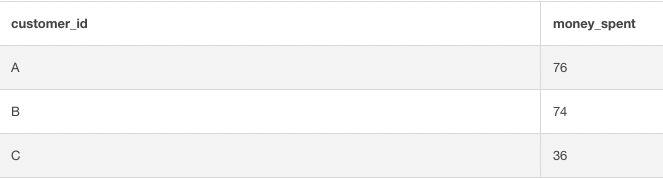

## Q2. How many days has each customer visited the restaurant?

In [ ]:
select a.customer_id,
       count(distinct a.order_date) as Unique_days_visited_restaurant
from dannys_diner.sales a
group by 1
order by 1

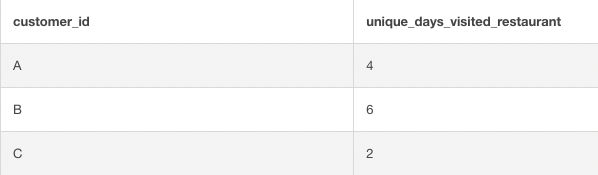

## Q3. What was the first item from the menu purchased by each customer? 

In [ ]:
with base_tbl as 
(
  select a.customer_id,
       c.product_name,
       dense_rank() over (partition by a.customer_id 
                          ORDER BY a.order_date asc) as first_item
from dannys_diner.sales a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on a.product_id = c.product_id
  )
select customer_id,
       product_name
from base_tbl
where first_item = 1
group by 1,2;

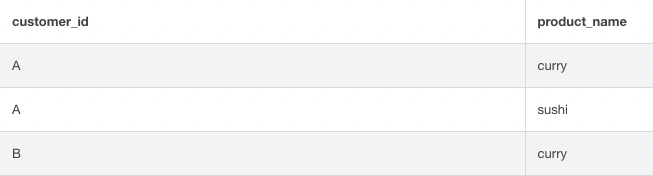

## Q4. What is the most purchased item on the menu and how many times was it purchased by all customers?

In [ ]:
select a.order_date,
       b.product_name,
       count(*) as no_of_placed_orders
from dannys_diner.sales a
join dannys_diner.menu b
 on a.product_id = b.product_id
group by 1,2
)
select product_name as most_ordered_product,
       sum(no_of_placed_orders) as total_orders
from base_tbl
group by 1
order by 2 desc
limit 1

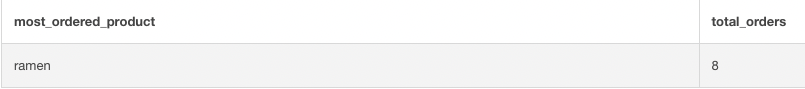

## Q5. Which item was the most popular for each customer?

In [ ]:
with base_tbl as (
select a.customer_id,
       a.product_id,
       b.product_name,
       count(*) as total_orders
from dannys_diner.sales a
join dannys_diner.menu b
on a.product_id =b.product_id
group by 1,2,3
),
second_tbl as (
select customer_id,
       product_name,
       total_orders,
       dense_rank() over (partition by customer_id order by total_orders desc) as rank
from base_tbl
)
select customer_id,
       product_name,
       total_orders
from second_tbl
where rank = 1

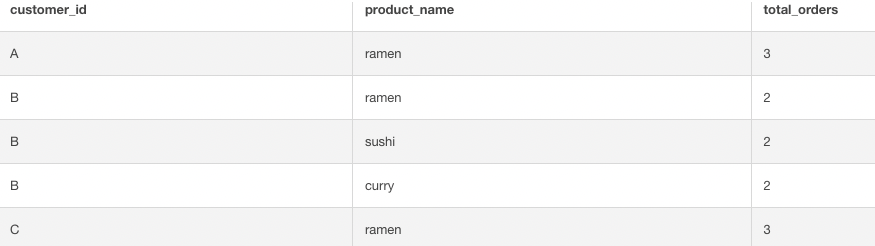

## Q6. Which item was purchased first by the customer after they became a member?

In [ ]:
with base as (
select a.customer_id,
       c.product_name,
       dense_rank() over (partition by a.customer_id 
                          order by a.order_date) as ranks
from dannys_diner.sales a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on a.product_id = c.product_id
where a.order_date >= b.join_date
)
select customer_id,
       product_name
from base
where ranks = 1

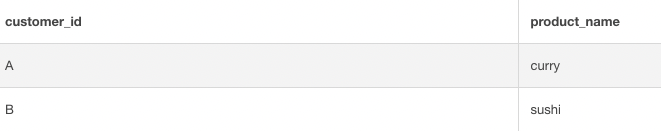

## Q7. Which item was purchased just before the customer became a member?

In [ ]:
with base as (
select a.customer_id,
       c.product_name,
       dense_rank() over (partition by a.customer_id 
                          order by a.order_date desc) as ranks
from dannys_diner.sales a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on a.product_id = c.product_id
where a.order_date < b.join_date
)
select customer_id,
       product_name
from base
where ranks = 1

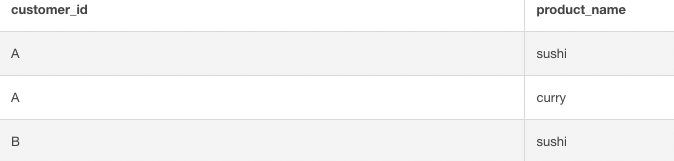

## Q8. What is the total items and amount spent for each member before they became a member?

In [ ]:
select a.customer_id,
       count(distinct b.product_id) as total_items,
       sum(c.price) sd amount_spent
from dannys_diner.members a
join dannys_diner.sales b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on c.product_id = b.product_id
where a.join_date > b.order_date
group by 1

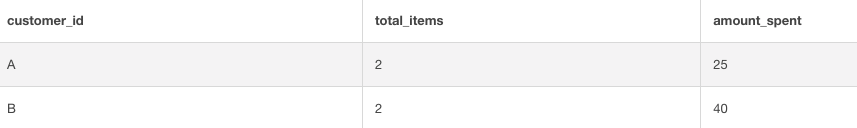

## Q9. If each dollar spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

In [ ]:
with base as (
select a.customer_id,
       b.product_name,
       sum(b.price) as amt
from dannys_diner.sales a
join dannys_diner.menu b
on a.product_id = b.product_id
group by 1,2
),
points as (
select customer_id,
  case when product_name = 'sushi' then amt*20
       when product_name = 'curry' then amt*10
       when product_name = 'ramen' then amt*10
  end as amount
from base
)
select customer_id,
       sum(amount)
from points
group by 1
order by 1

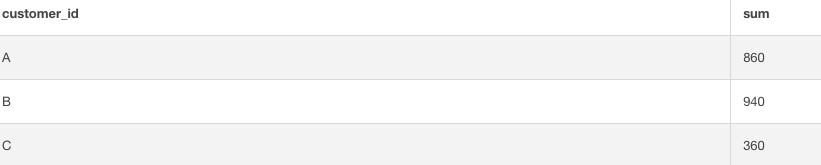

## Q10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [ ]:
WITH dates_cte AS 
(
 SELECT *, 
  (join_date + INTERVAL '6 days')::date AS valid_date, 
  '2021-01-31'::date AS last_date
 FROM dannys_diner.members AS m
)
select b.customer_id,
       b.join_date,
       a.valid_date,
       a.last_date,
       sum( case when d.product_name = 'sushi' then 2 * 10 * d.price 
                 when c.order_date between a.join_date and a.valid_date then 2 * 10 * d.price else 10 * d.price end ) as points
from dates_cte a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.sales c
on c.customer_id = a.customer_id
join dannys_diner.menu d
on d.product_id = c.product_id
where c.order_date<last_date
group by 1,2,3,4

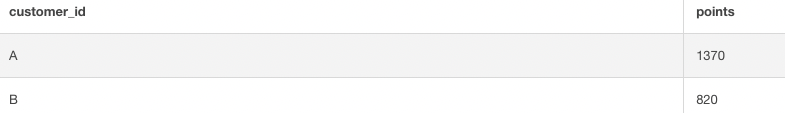

## Bonus Questions

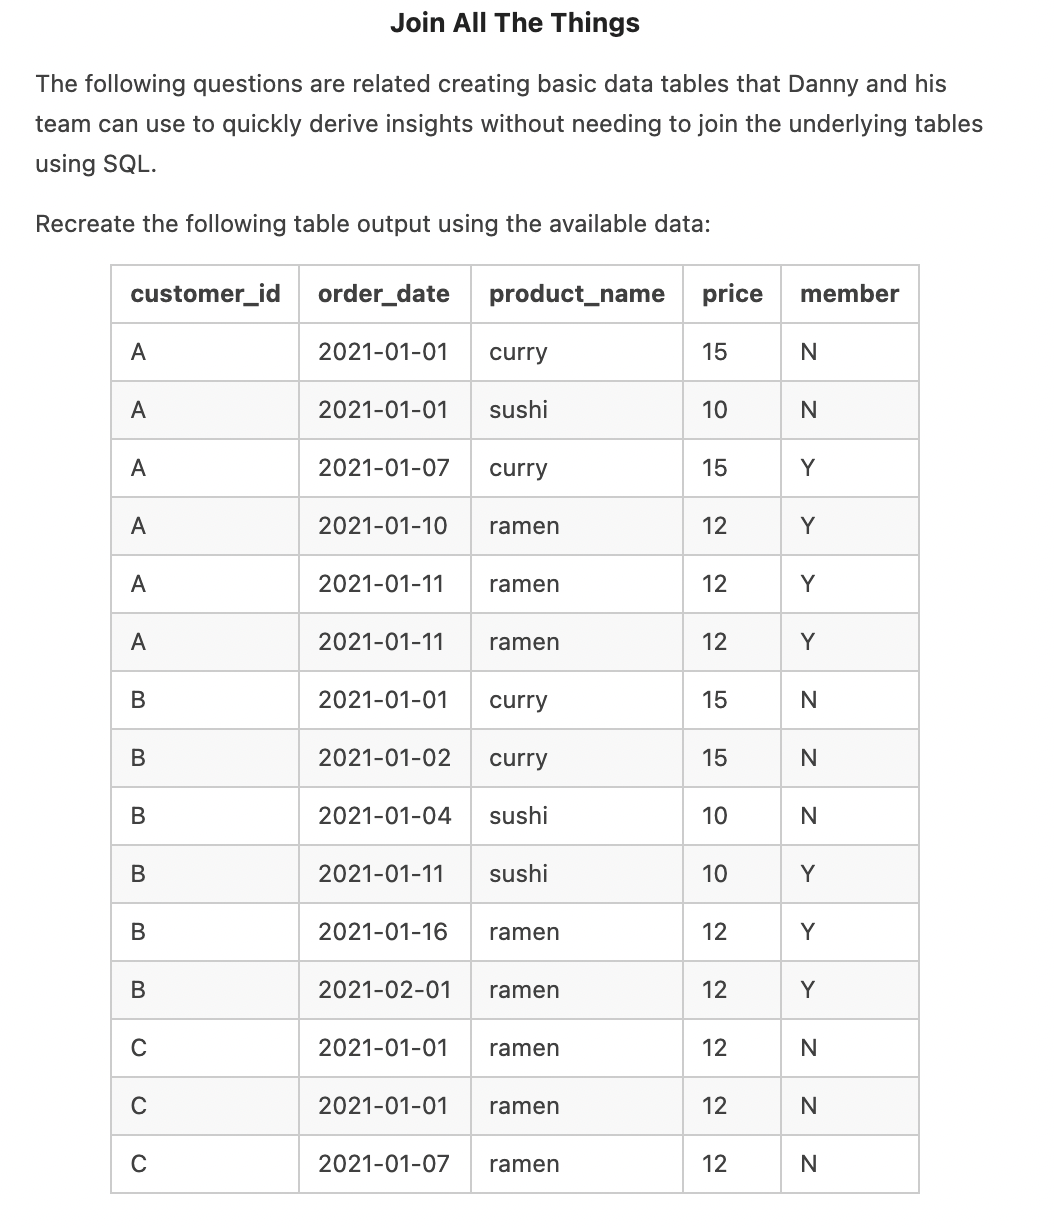

In [ ]:
select a.customer_id,
       a.order_date,
       c.product_name,
       c.price,
       case when a.order_date >= b.join_date then 'Y'
            when a.order_date < b.join_date then 'N'
            else 'N' end as member
from dannys_diner.sales a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on c.product_id = a.product_id
group by 1,2,3,4,5

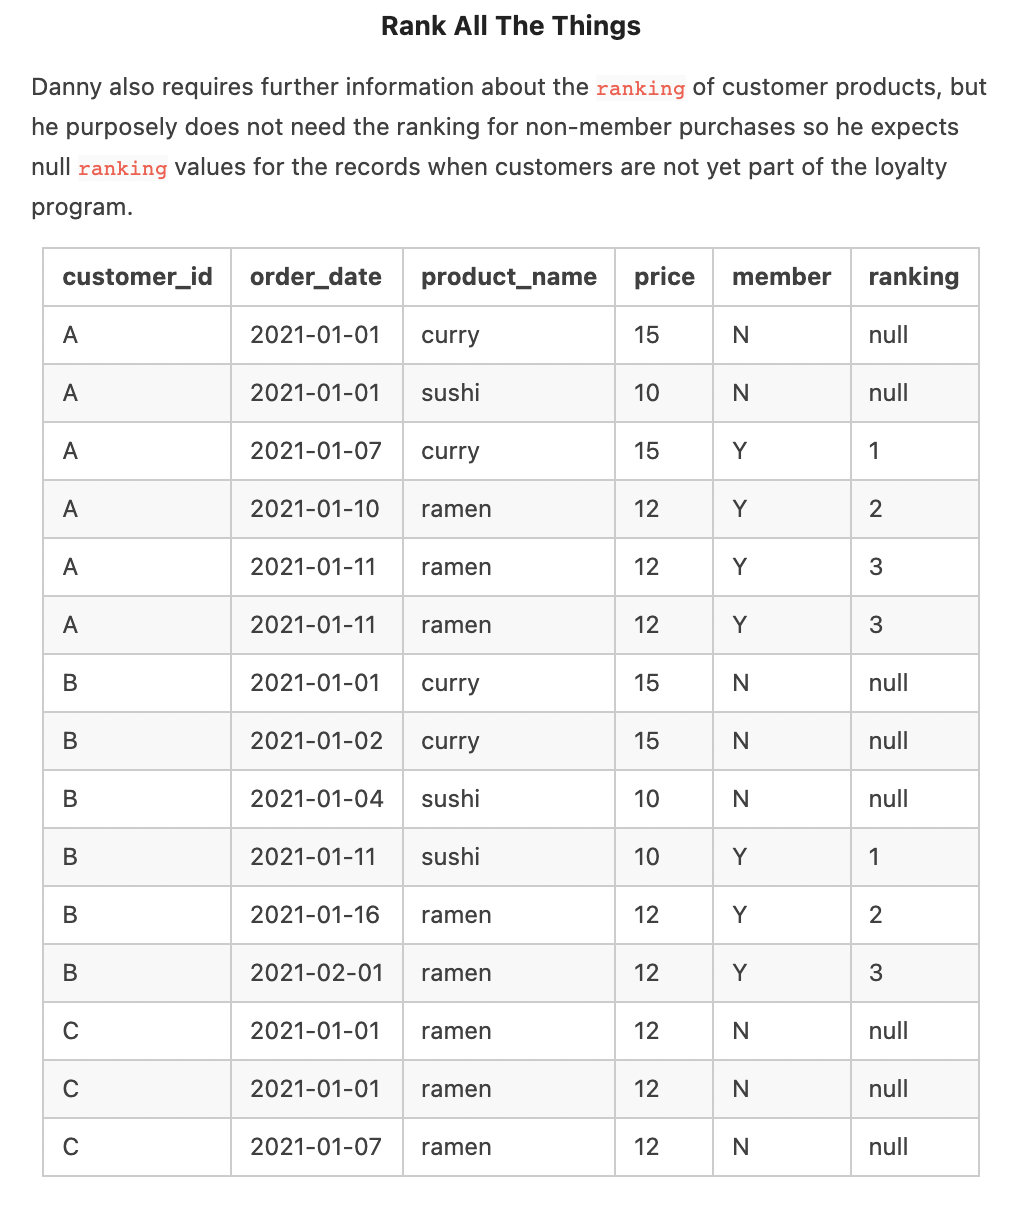

In [ ]:
with base as (
select a.customer_id,
       a.order_date,
       c.product_name,
       c.price,
       case when a.order_date >= b.join_date then 'Y'
            when a.order_date < b.join_date then 'N'
            else 'N' end as member
from dannys_diner.sales a
join dannys_diner.members b
on a.customer_id = b.customer_id
join dannys_diner.menu c
on c.product_id = a.product_id
group by 1,2,3,4,5
)
SELECT *, 
CASE
 WHEN member = 'N' then NULL
 ELSE
  RANK () OVER(PARTITION BY customer_id, member
  ORDER BY order_date) END AS ranking
FROM base;